In [1]:
%matplotlib inline

# import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.api import VAR, DynamicVAR
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.vector_ar.vecm import coint_johansen

from scipy import stats

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

sns.set()

RAW_DATA_PATH = ".\\data\\raw\\"
DATA_PATH = ".\\data\\"

In [2]:
# suppress warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

In [3]:
# read 'city_attributes.csv'  dataset as a dataframe
attrib = pd.read_csv(RAW_DATA_PATH + 'city_attributes.csv', low_memory =  False)
print(attrib.shape)
print(attrib.info(verbose = True, null_counts = True))
print(attrib[attrib.City == 'San Francisco'])

(36, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 4 columns):
City         36 non-null object
Country      36 non-null object
Latitude     36 non-null float64
Longitude    36 non-null float64
dtypes: float64(2), object(2)
memory usage: 1.2+ KB
None
            City        Country   Latitude   Longitude
2  San Francisco  United States  37.774929 -122.419418


In [4]:
# Function to convert temperature from Kelvin into Fahrenite.
def convert_temp_kelvin_to_fahr(x):
    return ((x -273.15) * 1.8 + 32)

# Function to convert pressure from hPa into inches of Mercury.
def convert_press_hpa_to_inches_of_mercury(x):
        return (x * 0.02952998)

#Function to convert wind-speed from m/s to mph
def convert_ws_meterpersec_to_milesperhour(x):
    return (x *  2.2369362920544)

In [5]:
# read 'temperature.csv'  dataset as a dataframe
temperature = pd.read_csv(RAW_DATA_PATH + 'temperature.csv', low_memory =  False)
print(temperature.shape)
temperature.info(verbose = True, null_counts = True)

# Convert index column to datetime dtype.
temperature.datetime = pd.to_datetime(temperature.datetime, infer_datetime_format = True)
temperature.set_index('datetime', inplace = True)

# temperature is in Kelvin. Convert it to Fahrenite.
for i in range(temperature.columns.size):
    temperature.iloc[:,i] = temperature.iloc[:,i].apply(convert_temp_kelvin_to_fahr) 

(45253, 37)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45253 entries, 0 to 45252
Data columns (total 37 columns):
datetime             45253 non-null object
Vancouver            44458 non-null float64
Portland             45252 non-null float64
San Francisco        44460 non-null float64
Seattle              45250 non-null float64
Los Angeles          45250 non-null float64
San Diego            45252 non-null float64
Las Vegas            45252 non-null float64
Phoenix              45250 non-null float64
Albuquerque          45252 non-null float64
Denver               45252 non-null float64
San Antonio          45252 non-null float64
Dallas               45249 non-null float64
Houston              45250 non-null float64
Kansas City          45252 non-null float64
Minneapolis          45240 non-null float64
Saint Louis          45252 non-null float64
Chicago              45250 non-null float64
Nashville            45251 non-null float64
Indianapolis         45246 non-null float64


In [6]:
# read 'pressure.csv'  dataset as a dataframe
pressure = pd.read_csv(RAW_DATA_PATH + 'pressure.csv', low_memory =  False)
print(pressure.shape)

# Convert index column to datetime dtype.
pressure.datetime = pd.to_datetime(pressure.datetime, infer_datetime_format = True)
pressure.set_index('datetime', inplace = True)

# Pressure is in hPa. Convert it to inches of mercury
for i in range(pressure.columns.size):
    pressure.iloc[:,i] = pressure.iloc[:,i].apply(convert_press_hpa_to_inches_of_mercury) 

#print(pressure.info(verbose = True, null_counts = True))
#pressure.head(5)

(45253, 37)


In [10]:
# read 'humidity.csv'  dataset as a dataframe
humidity = pd.read_csv(RAW_DATA_PATH + 'humidity.csv', low_memory =  False)
print(humidity.shape)

# Convert index column to datetime dtype.
humidity.datetime = pd.to_datetime(humidity.datetime, infer_datetime_format = True)
humidity.set_index('datetime', inplace = True)

#print(pressure.info(verbose = True, null_counts = True))
#print(humidity.tail(5))
print(humidity['San Francisco'].describe())

(45253, 37)
count    44311.000000
mean        76.875042
std         17.396016
min          6.000000
25%         68.000000
50%         81.000000
75%         89.000000
max        100.000000
Name: San Francisco, dtype: float64


In [11]:
# read 'wind_speed.csv'  dataset as a dataframe
wind_speed = pd.read_csv(RAW_DATA_PATH + 'wind_speed.csv', low_memory =  False)
print(wind_speed.shape)

# Convert index column to datetime dtype.
wind_speed.datetime = pd.to_datetime(wind_speed.datetime, infer_datetime_format = True)
wind_speed.set_index('datetime', inplace = True)

# Wind speed is meter/se. Convert it to miles per hour
for i in range(wind_speed.columns.size):
    wind_speed.iloc[:,i] = wind_speed.iloc[:,i].apply(convert_ws_meterpersec_to_milesperhour) 

#print(wind_speed.info(verbose = True, null_counts = True))
#print(wind_speed.head(5))
#print(wind_speed['San Francisco'].describe())
#print(wind_speed['San Francisco'].unique())

(45253, 37)


In [12]:
# read 'wind_direction.csv'  dataset as a dataframe
wind_direction = pd.read_csv(RAW_DATA_PATH + 'wind_direction.csv', low_memory =  False)
print(wind_direction.shape)

# Convert index column to datetime dtype.
wind_direction.datetime = pd.to_datetime(wind_direction.datetime, infer_datetime_format = True)
wind_direction.set_index('datetime', inplace = True)

#print(wind_direction.info(verbose = True, null_counts = True))
#print(wind_direction.head(5))
#print(wind_direction['San Francisco'].describe())
#print(sorted(wind_direction['San Francisco'].unique()))

(45253, 37)


In [10]:
# read 'weather_description.csv'  dataset as a dataframe
weather_description = pd.read_csv(RAW_DATA_PATH + 'weather_description.csv', low_memory =  False)
print(weather_description.shape)

# Convert index column to datetime dtype.
weather_description.datetime = pd.to_datetime(weather_description.datetime, infer_datetime_format = True)
weather_description.set_index('datetime', inplace = True)

#print(weather_description.info(verbose = True, null_counts = True))
#print(weather_description.head(5))
print(len(set(weather_description.values.flatten())))


(45253, 37)
55


In [11]:
# read 'city_attributes.csv'  dataset as a dataframe
city_attributes = pd.read_csv(RAW_DATA_PATH + 'city_attributes.csv', low_memory =  False)
print(city_attributes.shape)
city_attributes.set_index('City', inplace = True)

print(city_attributes.info(verbose = True, null_counts = True))
print(city_attributes.head(5))

(36, 4)
<class 'pandas.core.frame.DataFrame'>
Index: 36 entries, Vancouver to Jerusalem
Data columns (total 3 columns):
Country      36 non-null object
Latitude     36 non-null float64
Longitude    36 non-null float64
dtypes: float64(2), object(1)
memory usage: 1.1+ KB
None
                     Country   Latitude   Longitude
City                                               
Vancouver             Canada  49.249660 -123.119339
Portland       United States  45.523449 -122.676208
San Francisco  United States  37.774929 -122.419418
Seattle        United States  47.606209 -122.332069
Los Angeles    United States  34.052231 -118.243683


In [8]:
df = pd.DataFrame()
cities_cnt = pressure.shape[1]
cities = pressure.columns

# The dataset will have Temp, pressure, humidity and wind speed in this order for each city as columns
# Column name will be city_name.feature_name

for i in range(cities_cnt):
    col_name = cities[i] + '.pressure'
    df[col_name] = pressure[cities[i]]

# delete the entries for which SF temperature is empty
# since one month entries are missing for SF so making all cities time series same
rows = []
temp = df['San Francisco.pressure'].isna()

for i in range(0, len(temp)):
    if (temp[i]):
        rows.append(df.index[i])
        
df.drop(rows, 0, inplace = True)

# forward fill the rest of the missing values 
df.fillna(method = 'ffill', inplace = True)

# backward fill the rest of the missing values 
df.fillna(method = 'bfill', inplace = True)

print(df.shape)
#print(df.info(verbose = True, null_counts = True))
# save it for models
df.to_csv(DATA_PATH + "weather_pressure.csv")

(44438, 36)


In [13]:
df = pd.DataFrame()
cities_cnt = humidity.shape[1]
cities = humidity.columns

# The dataset will have Temp, pressure, humidity and wind speed in this order for each city as columns
# Column name will be city_name.feature_name

for i in range(cities_cnt):
    col_name = cities[i] + '.humidity'
    df[col_name] = humidity[cities[i]]

# delete the entries for which SF temperature is empty
# since one month entries are missing for SF so making all cities time series same
rows = []
temp = df['San Francisco.humidity'].isna()

for i in range(0, len(temp)):
    if (temp[i]):
        rows.append(df.index[i])
        
df.drop(rows, 0, inplace = True)

# forward fill the rest of the missing values 
df.fillna(method = 'ffill', inplace = True)

# backward fill the rest of the missing values 
df.fillna(method = 'bfill', inplace = True)

print(df.shape)
#print(df.info(verbose = True, null_counts = True))
# save it for models
df.to_csv(DATA_PATH + "weather_humidity.csv")

(44311, 36)


In [14]:
df = pd.DataFrame()
cities_cnt = wind_speed.shape[1]
cities = wind_speed.columns

# The dataset will have Temp, pressure, humidity and wind speed in this order for each city as columns
# Column name will be city_name.feature_name

for i in range(cities_cnt):
    col_name = cities[i] + '.wind_speed'
    df[col_name] = wind_speed[cities[i]]

# delete the entries for which SF temperature is empty
# since one month entries are missing for SF so making all cities time series same
rows = []
temp = df['San Francisco.wind_speed'].isna()

for i in range(0, len(temp)):
    if (temp[i]):
        rows.append(df.index[i])
        
df.drop(rows, 0, inplace = True)

# forward fill the rest of the missing values 
df.fillna(method = 'ffill', inplace = True)

# backward fill the rest of the missing values 
df.fillna(method = 'bfill', inplace = True)

print(df.shape)
#print(df.info(verbose = True, null_counts = True))
# save it for models
df.to_csv(DATA_PATH + "weather_wind_speed.csv")

(44459, 36)


In [15]:
df = pd.DataFrame()
cities_cnt = wind_direction.shape[1]
cities = wind_direction.columns

# The dataset will have Temp, pressure, humidity and wind speed in this order for each city as columns
# Column name will be city_name.feature_name

for i in range(cities_cnt):
    col_name = cities[i] + '.wind_direction'
    df[col_name] = wind_speed[cities[i]]

# delete the entries for which SF temperature is empty
# since one month entries are missing for SF so making all cities time series same
rows = []
temp = df['San Francisco.wind_direction'].isna()

for i in range(0, len(temp)):
    if (temp[i]):
        rows.append(df.index[i])
        
df.drop(rows, 0, inplace = True)

# forward fill the rest of the missing values 
df.fillna(method = 'ffill', inplace = True)

# backward fill the rest of the missing values 
df.fillna(method = 'bfill', inplace = True)

print(df.shape)
#print(df.info(verbose = True, null_counts = True))
# save it for models
df.to_csv(DATA_PATH + "weather_wind_direction.csv")

(44459, 36)


In [16]:
df = pd.DataFrame()
cities_cnt = temperature.shape[1]
cities = temperature.columns

# The dataset will have Temp, pressure, humidity and wind speed in this order for each city as columns
# Column name will be city_name.feature_name
# Smoothing: add 0.001 in Wind Direction and Wind Speed to avoid divide by zero error
for i in range(cities_cnt):
    col_name = cities[i] + '.temperature'
    df[col_name] = temperature[cities[i]]
    col_name = cities[i] + '.pressure'
    df[col_name] = pressure[cities[i]]
    col_name = cities[i] + '.humidity'
    df[col_name] = humidity[cities[i]]
    col_name = cities[i] + '.wind_speed'
    df[col_name] = wind_speed[cities[i]] + 0.001
    col_name = cities[i] + '.wind_direction'
    df[col_name] = wind_direction[cities[i]] + 0.001

# delete the entries for which SF temperature is empty
# since one month entries are missing for SF so making all cities time series same
rows = []
temp = df['San Francisco.temperature'].isna()

for i in range(0, len(temp)):
    if (temp[i]):
        rows.append(df.index[i])
        
df.drop(rows, 0, inplace = True)

# forward fill the rest of the missing values 
df.fillna(method = 'ffill', inplace = True)

# backward fill the rest of the missing values 
df.fillna(method = 'bfill', inplace = True)

for i in range(cities_cnt):
    col_name = cities[i] + '.latitude'
    df[col_name] = city_attributes.loc[cities[i], 'Latitude']
    col_name = cities[i] + '.longitude'
    df[col_name] = city_attributes.loc[cities[i], 'Longitude']
print(df.shape)
print(df.info(verbose = True, null_counts = True))
# save it for models
df.to_csv(DATA_PATH + "weather_all.csv")

(44460, 252)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44460 entries, 2012-10-01 13:00:00 to 2017-10-28 00:00:00
Data columns (total 252 columns):
Vancouver.temperature               44460 non-null float64
Vancouver.pressure                  44460 non-null float64
Vancouver.humidity                  44460 non-null float64
Vancouver.wind_speed                44460 non-null float64
Vancouver.wind_direction            44460 non-null float64
Portland.temperature                44460 non-null float64
Portland.pressure                   44460 non-null float64
Portland.humidity                   44460 non-null float64
Portland.wind_speed                 44460 non-null float64
Portland.wind_direction             44460 non-null float64
San Francisco.temperature           44460 non-null float64
San Francisco.pressure              44460 non-null float64
San Francisco.humidity              44460 non-null float64
San Francisco.wind_speed            44460 non-null float64
San Francisco.wi

In [14]:
# Filter  rows which have empty Temperature values
tcopy = temperature.copy()
rows = []
temp = tcopy['San Francisco'].isna()
for i in range(0, len(temp)):
    if (temp[i]):
        rows.append(tcopy.index[i])
        
tcopy.drop(rows, 0, inplace = True)

# forward fill the rest of the missing values 
tcopy.fillna(method = 'ffill', inplace = True)
#print(tcopy.info(verbose = True, null_counts = True))
tcopy.to_csv(DATA_PATH + "weather_temperature.csv")

In [15]:
# Create a dataset for all the attributes of San Francisco
SF = temperature.copy()
drop_list = [col for col in SF.columns if col not in ['San Francisco']]
SF.drop(labels=drop_list, axis=1, inplace=True)
SF.columns = ['Temperature']
SF['Pressure'] = pressure['San Francisco']
SF['Humidity'] = humidity['San Francisco']
SF['Wind Speed'] = wind_speed['San Francisco']
SF['Wind Direction'] = wind_speed['San Francisco']
SF['Weather Description'] = weather_description['San Francisco']

# Filter  rows which have empty Temperature values
rows = []
temp = SF.Temperature.isna()
for i in range(0, len(temp)):
    if (temp[i]):
        rows.append(SF.index[i])
        
SF.drop(rows, 0, inplace = True)

## forward fill the rest of the missing values 
SF.fillna(method = 'ffill', inplace = True)

# backward fill the rest of the missing values 
SF.fillna(method = 'bfill', inplace = True)

# Smoothing: add 0.001 in all entries to avoid divide by zero error
SF['Wind Direction'] = SF['Wind Direction'] + 0.001
SF['Wind Speed'] = SF['Wind Speed'] + 0.001

print(SF.info(verbose = True, null_counts = True))

#onehot_encoder = OneHotEncoder()
#cat_array = SF['Weather Description'].values.reshape(-1, 1)
#weather_desc_1hot = onehot_encoder.fit_transform(cat_array)
#onehot_array = weather_desc_1hot.toarray()
#print(onehot_array.shape)
#for i in range(onehot_array.shape[1]):
#    SF[str(i)] = onehot_array[:,i]
    
SF.drop(['Weather Description'], axis = 1, inplace = True)
    
#print(SF.info(verbose = True, null_counts = True))
print(SF.head(5))
# Dataset is ready for further EDA and Data Modelling. Saved the dataset as SF.csv.
SF.to_csv(DATA_PATH + "SF.csv")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44460 entries, 2012-10-01 13:00:00 to 2017-10-28 00:00:00
Data columns (total 6 columns):
Temperature            44460 non-null float64
Pressure               44460 non-null float64
Humidity               44460 non-null float64
Wind Speed             44460 non-null float64
Wind Direction         44460 non-null float64
Weather Description    44460 non-null object
dtypes: float64(5), object(1)
memory usage: 2.4+ MB
None
                     Temperature  Pressure  Humidity  Wind Speed  \
datetime                                                           
2012-10-01 13:00:00    61.394000  29.79575      88.0    4.474873   
2012-10-01 14:00:00    61.384987  29.79575      87.0    4.474873   
2012-10-01 15:00:00    61.359113  29.79575      86.0    4.474873   
2012-10-01 16:00:00    61.333238  29.79575      85.0    4.474873   
2012-10-01 17:00:00    61.307364  29.79575      84.0    4.474873   

                     Wind Direction  
datetime  

In [16]:
SF.describe()

,Temperature,Pressure,Humidity,Wind Speed,Wind Direction
count,44460.000000,44460.000000,44460.000000,44460.000000,44460.000000
mean,59.010477,30.086367,76.842218,6.234787,6.234787
std,9.599152,0.216565,17.416273,5.109183,5.109183
min,30.470000,29.087030,6.000000,0.001000,0.001000
25%,52.736000,29.943400,68.000000,2.237936,2.237936
50%,58.028000,30.061520,81.000000,4.474873,4.474873
75%,64.157300,30.209170,89.000000,8.948745,8.948745
max,104.846000,30.829299,100.000000,96.189261,96.189261


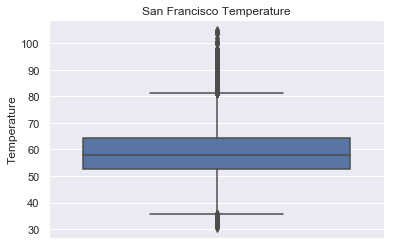

In [17]:
sns.boxplot(data = SF, y = 'Temperature')
plt.ylabel('Temperature')
plt.title('San Francisco Temperature')
plt.show()

The above Box Plot shows that there are some outliers according to the statistics. We will not try to change anything for these outliers since they represent extreme weather conditions which happen in real world time to time. We want to model the time series using these outliers and see if the model can find a pattern and predict the extreme weather for future.

### Resampling and Converting Frequencies
###### The primary difference between the resample and asfreq is that resample() is fundamentally a data aggregation, while asfreq() is fundamentally a data selection. at each point, resample reports the average of the previous mont, while asfreq reports the value at the end of the month.

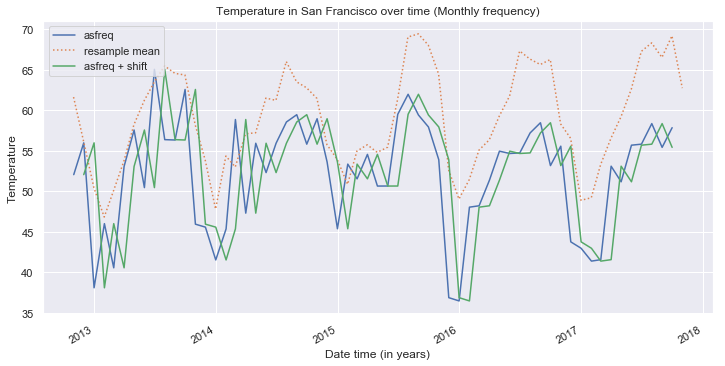

In [18]:
# asfreq method is used to convert a time series to a specified frequency. Here it is monthly frequency.
# Set figure width and height
plt.rcParams["figure.figsize"] = [12,6]

SF["Temperature"].asfreq('M').plot() 
SF['Temperature'].resample('M').mean().plot(style=':')
SF["Temperature"].asfreq('M').shift(1).plot()  # lagged by a month

plt.title('Temperature in San Francisco over time (Monthly frequency)')
plt.ylabel('Temperature')
plt.xlabel('Date time (in years)')
plt.legend(['asfreq', 'resample mean', 'asfreq + shift'],
           loc='upper left');
plt.show()

The above plot shows the monthly temperature of San francisco and second graph show the temperature at a lag of  one month. The graph consists of straight lines which indicates Temperature is a Linear Time Series so gradient is constant between two local minima and maxima values of the graph.The gradiets changes between positive and negative value over the period of time. Negative gradient indicates negative correlation and positive gradient indicates positive relationship between time and values of the Temperature.

### Pressure

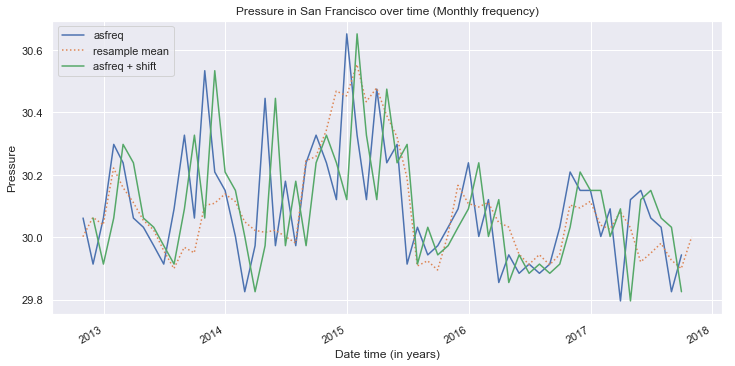

In [19]:
# asfreq method is used to convert a time series to a specified frequency. Here it is monthly frequency.
# Set figure width and height
plt.rcParams["figure.figsize"] = [12,6]

SF["Pressure"].asfreq('M').plot() 
SF['Pressure'].resample('M').mean().plot(style=':')
SF["Pressure"].asfreq('M').shift(1).plot()  # lagged by a month

plt.title('Pressure in San Francisco over time (Monthly frequency)')
plt.ylabel('Pressure')
plt.xlabel('Date time (in years)')
plt.legend(['asfreq', 'resample mean', 'asfreq + shift'],
           loc='upper left');
plt.show()

### Humidity

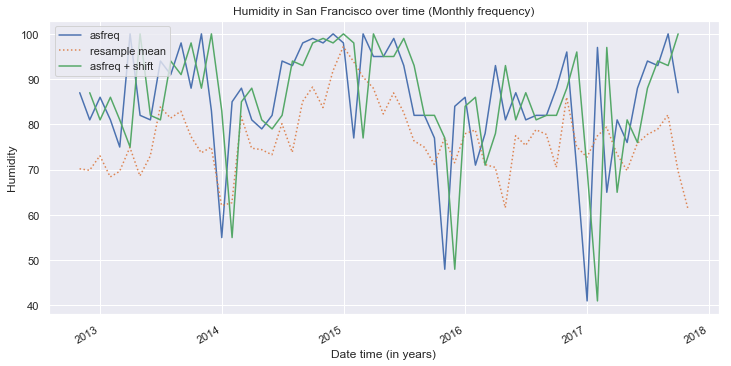

In [20]:
# asfreq method is used to convert a time series to a specified frequency. Here it is monthly frequency.
# Set figure width and height
plt.rcParams["figure.figsize"] = [12,6]

SF["Humidity"].asfreq('M').plot() 
SF['Humidity'].resample('M').mean().plot(style=':')
SF["Humidity"].asfreq('M').shift(1).plot()  # lagged by a month

plt.title('Humidity in San Francisco over time (Monthly frequency)')
plt.ylabel('Humidity')
plt.xlabel('Date time (in years)')
plt.legend(['asfreq', 'resample mean', 'asfreq + shift'],
           loc='upper left');
plt.show()

### Wind Speed

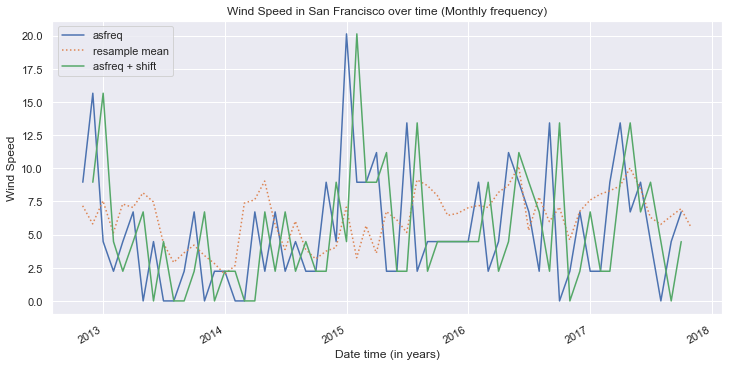

In [21]:
# asfreq method is used to convert a time series to a specified frequency. Here it is monthly frequency.
# Set figure width and height
plt.rcParams["figure.figsize"] = [12,6]

SF['Wind Speed'].asfreq('M').plot() 
SF['Wind Speed'].resample('M').mean().plot(style=':')
SF['Wind Speed'].asfreq('M').shift(1).plot()  # lagged by a month

plt.title('Wind Speed in San Francisco over time (Monthly frequency)')
plt.ylabel('Wind Speed')
plt.xlabel('Date time (in years)')
plt.legend(['asfreq', 'resample mean', 'asfreq + shift'],
           loc='upper left');
plt.show()

### Time shifts
###### Pandas has two closely related methods for computing time shifts: shift() and tshift() In short, the difference between them is that shift() shifts the data, while tshift() shifts the index. In both cases, the shift is specified in multiples of the frequency.
###### Here we will both shift() and tshift() by 12 months. We see here that shift(12) shifts the data by 12 months, while tshift(12) shifts the index values by 12 months.

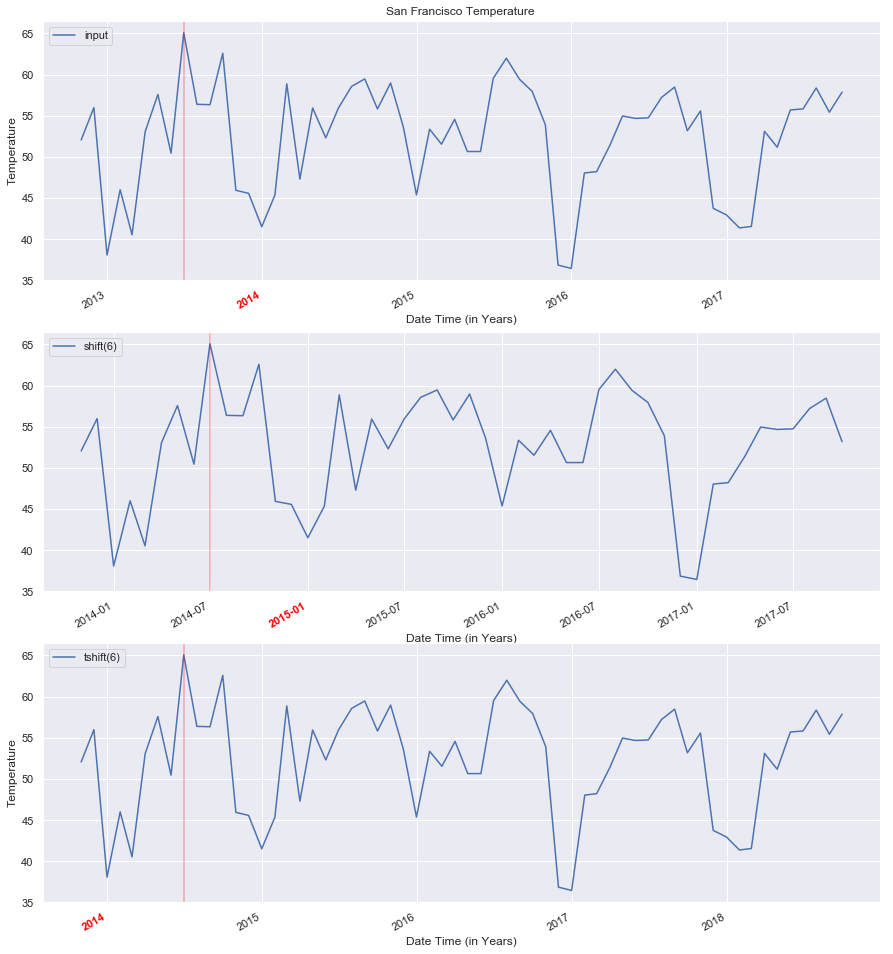

In [22]:
plt.rcParams["figure.figsize"] = [15,18]
fig, ax = plt.subplots(3, sharey=True)

# apply a frequency to the data
temp = SF["Temperature"].asfreq('M')

temp.plot(ax = ax[0])
temp.shift(12).plot(ax=ax[1])
temp.tshift(12).plot(ax=ax[2])

# legends and annotations
local_max = pd.to_datetime('2013-06-30')
offset = pd.Timedelta(12, 'M')

ax[0].legend(['input'], loc=2)
ax[0].get_xticklabels()[2].set(weight='heavy', color='red')
ax[0].axvline(local_max, alpha=0.3, color='red')
ax[0].set_ylabel('Temperature')
ax[0].set_xlabel('Date Time (in Years)')
ax[0].set_title('San Francisco Temperature ')
ax[1].legend(['shift(6)'], loc=2)
ax[1].get_xticklabels()[2].set(weight='heavy', color='red')
ax[1].axvline(local_max + offset, alpha=0.3, color='red')
ax[2].set_ylabel('Temperature')
ax[1].set_xlabel('Date Time (in Years)')

ax[2].legend(['tshift(6)'], loc=2)
ax[2].get_xticklabels()[1].set(weight='heavy', color='red')
ax[2].axvline(local_max + offset, alpha=0.3, color='red');
ax[2].set_ylabel('Temperature')
ax[2].set_xlabel('Date Time (in Years)')
plt.show()

### Rolling windows
###### Rolling statistics are  another type of time series-specific operation implemented by Pandas. These can be accomplished via the rolling() attribute of Series and DataFrame objects, which returns a view similar to what we saw with the groupby operation such as Aggregation and Grouping. This rolling view makes available a number of aggregation operations by default.
###### For example, here is the one-year centered rolling mean and standard deviation of the San Francisco Temperature:
The visuals of the plot show that rolling mean and rolling standard deviation are constant. Lets see below if we can see that in calculation also.

### Temperature

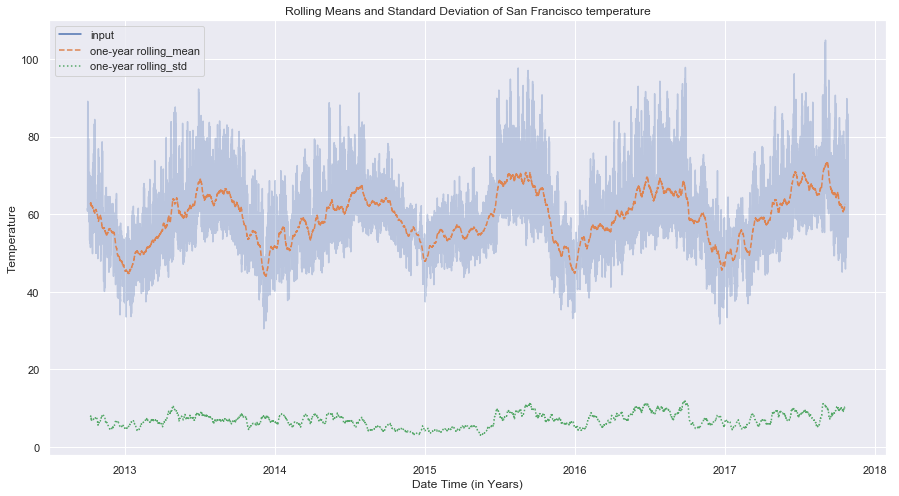

In [23]:
plt.rcParams["figure.figsize"] = [15,8]
rolling = SF.Temperature.rolling(365, center=True)

data = pd.DataFrame({'input': SF.Temperature,
                     'one-year rolling_mean': rolling.mean(),
                     'one-year rolling_std': rolling.std()})
ax = data.plot(style=['-', '--', ':'])
ax.lines[0].set_alpha(0.3)
ax.set_title('Rolling Means and Standard Deviation of San Francisco temperature')
ax.set_ylabel('Temperature')
ax.set_xlabel('Date Time (in Years)')
plt.show()

### Pressure

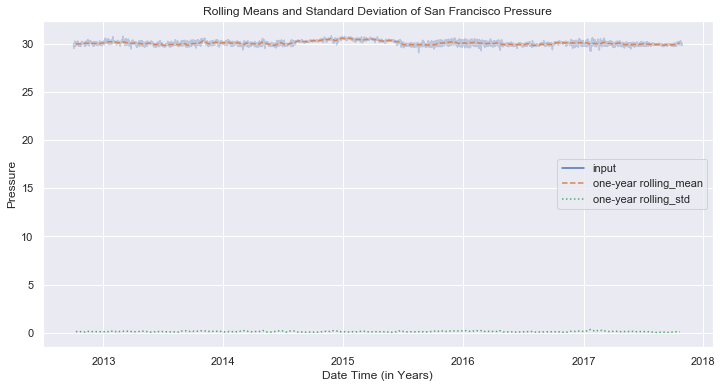

In [24]:
plt.rcParams["figure.figsize"] = [12,6]
rolling = SF.Pressure.rolling(365, center=True)

data = pd.DataFrame({'input': SF.Pressure,
                     'one-year rolling_mean': rolling.mean(),
                     'one-year rolling_std': rolling.std()})
ax = data.plot(style=['-', '--', ':'])
ax.lines[0].set_alpha(0.3)
ax.set_title('Rolling Means and Standard Deviation of San Francisco Pressure')
ax.set_ylabel('Pressure')
ax.set_xlabel('Date Time (in Years)')
plt.show()

### Humidity

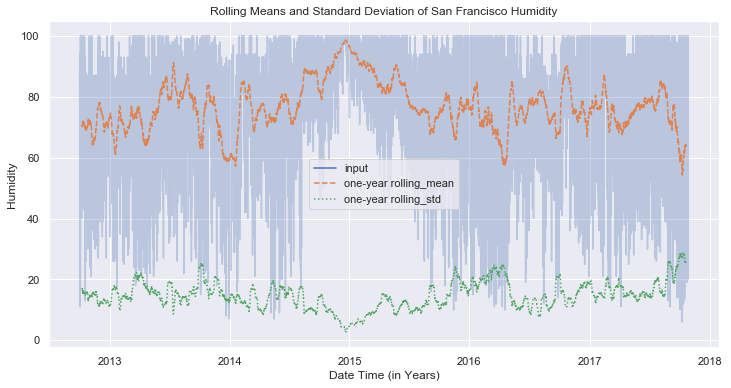

In [25]:
plt.rcParams["figure.figsize"] = [12,6]
rolling = SF.Humidity.rolling(365, center=True)

data = pd.DataFrame({'input': SF.Humidity,
                     'one-year rolling_mean': rolling.mean(),
                     'one-year rolling_std': rolling.std()})
ax = data.plot(style=['-', '--', ':'])
ax.lines[0].set_alpha(0.3)
ax.set_title('Rolling Means and Standard Deviation of San Francisco Humidity')
ax.set_ylabel('Humidity')
ax.set_xlabel('Date Time (in Years)')
plt.show()

### Wind Speed

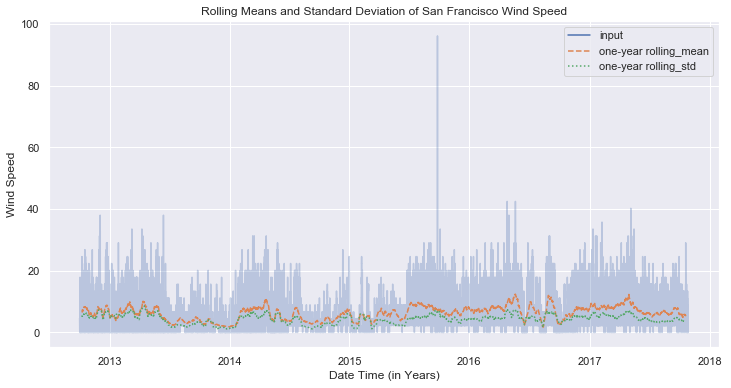

In [26]:
plt.rcParams["figure.figsize"] = [12,6]
rolling = SF['Wind Speed'].rolling(365, center=True)

data = pd.DataFrame({'input': SF['Wind Speed'],
                     'one-year rolling_mean': rolling.mean(),
                     'one-year rolling_std': rolling.std()})
ax = data.plot(style=['-', '--', ':'])
ax.lines[0].set_alpha(0.3)
ax.set_title('Rolling Means and Standard Deviation of San Francisco Wind Speed')
ax.set_ylabel('Wind Speed')
ax.set_xlabel('Date Time (in Years)')
plt.show()

### Time Series Histogrm and Density Plot

#### Deterministic vs Non deterministic Time series
###### Time series can be deterministic or non-deterministic in nature. Deterministic time series always behave in an expected manner where as non-deterministic time series is stochastic or random in nature. The following measure indicate is a time series is deterministic or not. 
##### Covariance Stationary - If a time series mean, variance and covariance with past and future values do not change over time then the model is known to be covariance stationary. Time series needs to meet following three criteria to be stationary:
###### 1. Constant Mean - Mean or expected value of a time series over successive time periods needs to be constant for a time series to be considered covariance stationary. This implies that the expected value should not be time dependent.
###### 2. Constant Variance - Variance or standard deviation of a time series needs to be constant over time and should not be dependent on time. This is the second criteria for a time series to be covariance stationary.
###### 3.  Constant Covariance -  If a covariance is not constant in a time series then the time series exhibits randomness. Additionally, time series distribution changes without any obvious pattern. This indicates that the time series time points have changing correlation. 

In [27]:
size = SF.shape[0]
print(size)
ts1 = SF.iloc[:int(size/2), :]
ts2 = SF.iloc[365 :(int(size/2) + 365):, :]
print(ts1.shape, ts2.shape)
print("first dataset: mean = {}, standard deviation {}".format(ts1.Temperature.mean(), ts1.Temperature.std()))
print("second dataset mean = {}, standard deviation {}".format(ts2.Temperature.mean(), ts2.Temperature.std()))
print(ts1.Temperature.cov(ts2.Temperature))

44460
(22230, 5) (22230, 5)
first dataset: mean = 57.490037978797375, standard deviation 8.543432586636433
second dataset mean = 57.386650030606404, standard deviation 8.490255989411327
72.77870714655963


The result from the cell above indicates mean and standard deviation are very similar in both sets of datasets. So the time series is Deterministic and Stationary.

### Augmented Dickey-Fuller Test
###### This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. 
The results below show that test statistics is much less than the critical value for time series for all weather attributes. So we reject the null hypothesis. So the time series are stationary.

In [28]:
#Perform Dicky Fuller test for stationarity

from statsmodels.tsa.stattools import adfuller
def test_stationarity(ts):
       #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    for col in ts.columns:
        print(ts[col].name)
        dftest = adfuller(ts[col], autolag='AIC')
        dfoutput = pd.Series(dftest[0:4], index=['    Test Statistic','    p-value','    #Lags Used','    Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['    Critical Value (%s)'%key] = value
        print (dfoutput)

test_stationarity(SF)

Results of Dickey-Fuller Test:
Temperature
    Test Statistic                -9.040569e+00
    p-value                        5.147027e-15
    #Lags Used                     5.600000e+01
    Number of Observations Used    4.440300e+04
    Critical Value (1%)           -3.430497e+00
    Critical Value (5%)           -2.861605e+00
    Critical Value (10%)          -2.566805e+00
dtype: float64
Pressure
    Test Statistic                -1.105989e+01
    p-value                        4.839065e-20
    #Lags Used                     5.600000e+01
    Number of Observations Used    4.440300e+04
    Critical Value (1%)           -3.430497e+00
    Critical Value (5%)           -2.861605e+00
    Critical Value (10%)          -2.566805e+00
dtype: float64
Humidity
    Test Statistic                -1.564841e+01
    p-value                        1.607769e-28
    #Lags Used                     5.300000e+01
    Number of Observations Used    4.440600e+04
    Critical Value (1%)           -3.430497e+

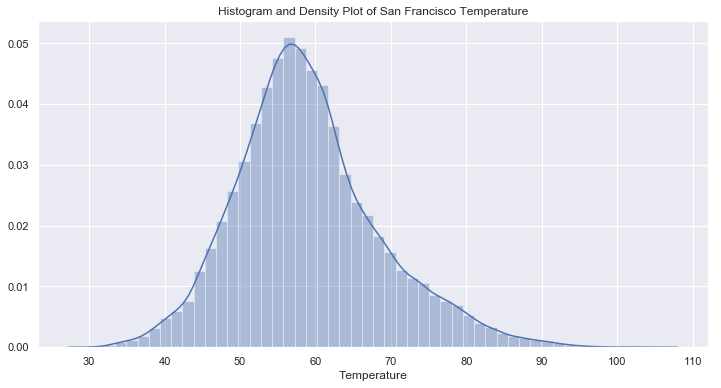

In [29]:
plt.rcParams["figure.figsize"] = [12,6]
ax = sns.distplot(SF.Temperature)
ax.set_title('Histogram and Density Plot of San Francisco Temperature')
plt.show()

The Density plot above shows that Temperature distribution is Normal distribution with little skewness to the right. Which could indicate outliers in higher temperatures. 

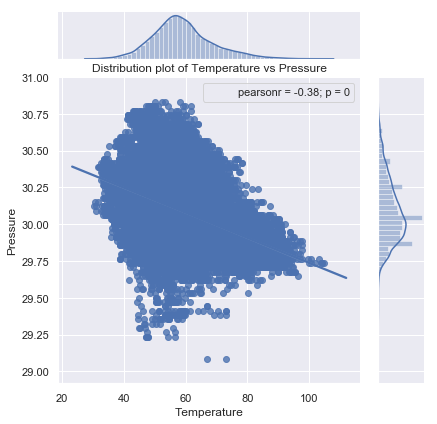

In [30]:
plt.rcParams["figure.figsize"] = [12,6]
sns.jointplot(data = SF, x = 'Temperature', y = 'Pressure', kind = 'reg', space = 0.4).annotate(stats.pearsonr).set_axis_labels('Temperature', 'Pressure')
plt.title('Distribution plot of Temperature vs Pressure')
plt.show()

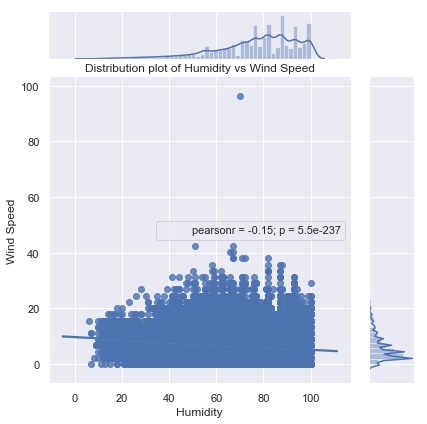

In [31]:
plt.rcParams["figure.figsize"] = [8,8]
sns.jointplot(data = SF, x = 'Humidity', y = 'Wind Speed', kind = 'reg', space = 0.4).annotate(stats.pearsonr).set_axis_labels('Humidity', 'Wind Speed')
plt.title('Distribution plot of Humidity vs Wind Speed')
plt.show()

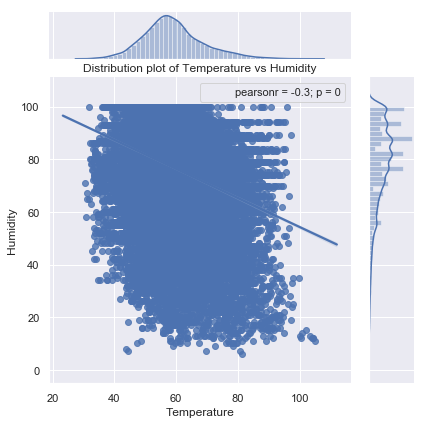

In [32]:
sns.jointplot(data = SF, x = 'Temperature', y = 'Humidity', kind = 'reg', space = 0.4).annotate(stats.pearsonr).set_axis_labels('Temperature', 'Humidity')
plt.title('Distribution plot of Temperature vs Humidity')
plt.show()

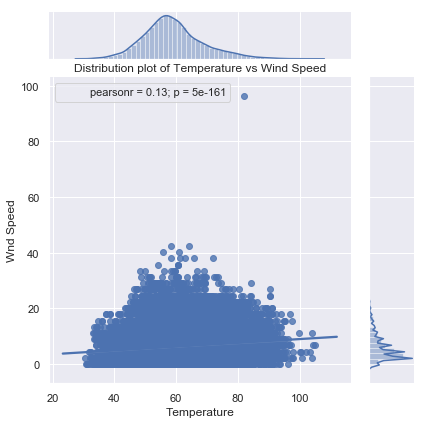

In [33]:
sns.jointplot(data = SF, x = 'Temperature', y = 'Wind Speed', kind = 'reg', space = 0.4).annotate(stats.pearsonr).set_axis_labels('Temperature', 'Wnd Speed')
plt.title('Distribution plot of Temperature vs Wind Speed')
plt.show()

### Seasonal Decomposition
###### Using time-series decomposition makes it easier to quickly identify a changing mean or variation in the data. The plots below clearly show that there is an yearly (long term) trend. Also there is constant seasonality. The residuals seem random with zero mean which makes it a white noise. These can be used to understand the structure of our time-series. The intuition behind time-series decomposition is important, as many forecasting methods build upon this concept of structured decomposition to produce forecasts.

In [34]:
print(SF.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44460 entries, 2012-10-01 13:00:00 to 2017-10-28 00:00:00
Freq: H
Data columns (total 5 columns):
Temperature       44460 non-null float64
Pressure          44460 non-null float64
Humidity          44460 non-null float64
Wind Speed        44460 non-null float64
Wind Direction    44460 non-null float64
dtypes: float64(5)
memory usage: 3.3 MB
None


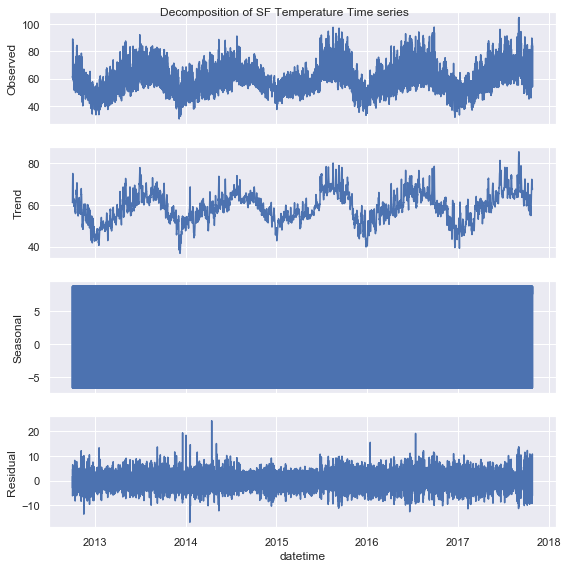

In [35]:
# Decomposition of SF Temperature Time series
result = seasonal_decompose(SF.Temperature, model='additive')
result.plot()
plt.suptitle('Decomposition of SF Temperature Time series')
plt.show()

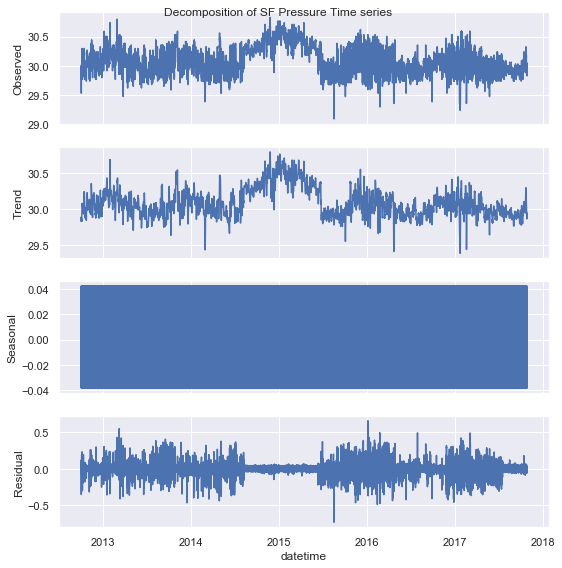

In [36]:
result = seasonal_decompose(SF.Pressure, model='additive')
result.plot()
plt.suptitle('Decomposition of SF Pressure Time series')
plt.show()

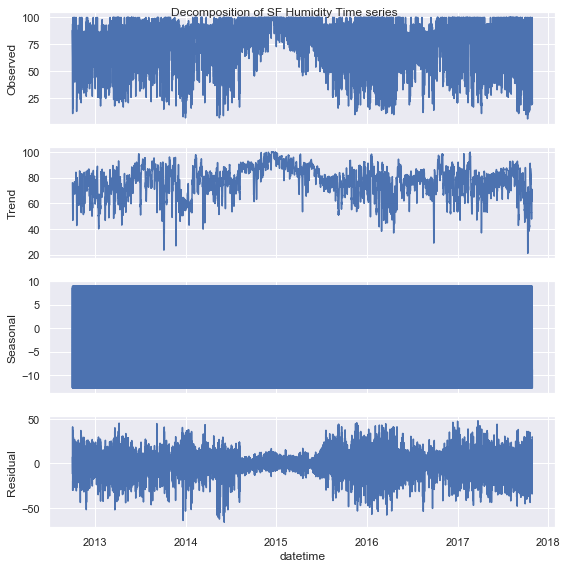

In [37]:
result = seasonal_decompose(SF.Humidity, model='additive')
result.plot()
plt.suptitle('Decomposition of SF Humidity Time series')
plt.show()

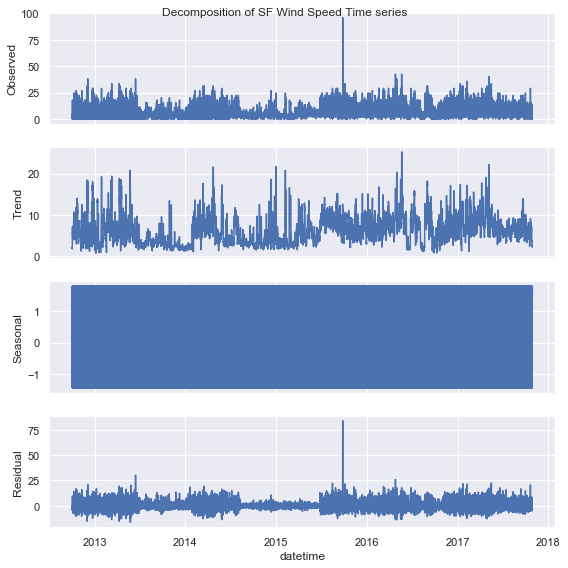

In [38]:
result = seasonal_decompose(SF['Wind Speed'], model='additive')
result.plot()
plt.suptitle('Decomposition of SF Wind Speed Time series')
plt.show()

### lag_plot 
###### A lag plot is a scatter plot for a time series and the same data lagged. With such a plot, we can check whether there is a possible correlation between current value and the lagged value.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

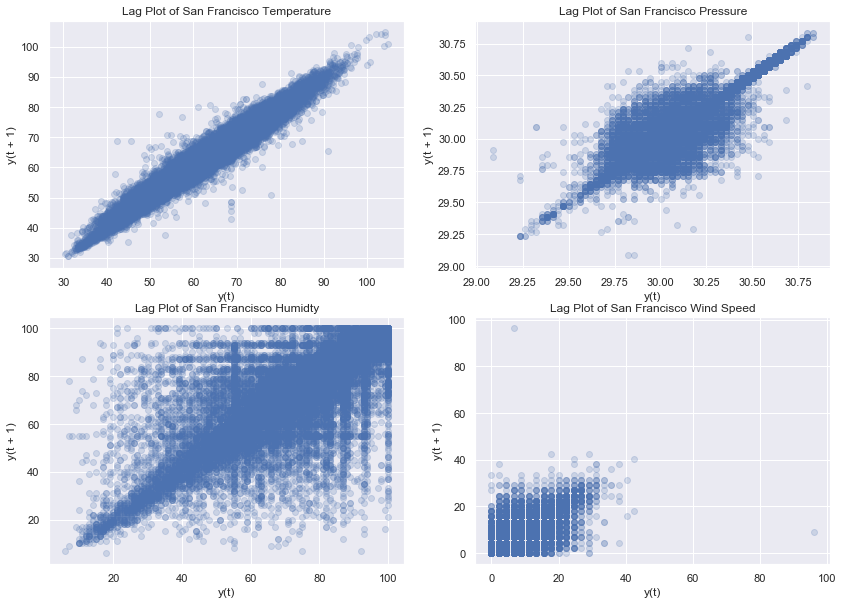

In [39]:
# lag_plot
plt.rcParams["figure.figsize"] = [14, 10]
f, (ax0, ax1) = plt.subplots(2, 2, sharex = False, sharey = False)

lag = 1
pd.plotting.lag_plot(SF.Temperature, alpha = 0.2, lag = lag, ax = ax0[0])
ax0[0].set_title('Lag Plot of San Francisco Temperature')

pd.plotting.lag_plot(SF.Pressure, alpha = 0.2, lag = lag, ax = ax0[1])
ax0[1].set_title('Lag Plot of San Francisco Pressure')

pd.plotting.lag_plot(SF.Humidity, alpha = 0.2, lag = lag, ax = ax1[0])
ax1[0].set_title('Lag Plot of San Francisco Humidty')

pd.plotting.lag_plot(SF['Wind Speed'], alpha = 0.2, lag = lag, ax = ax1[1])
ax1[1].set_title('Lag Plot of San Francisco Wind Speed')

plt.show()

Following observations can be made from the above plot.
1. A linear shape shows a relatively strong positive correlation between observations and their lag1 values. 
2. Also it suggests that an autoregressive model is probably a better choice.
3. Outliers are easily discernible on a lag plot. The following plot shows that there are several outliers.


### Auto Correlation Factor Plot 
##### We can calculate the correlation for time series observations with observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.
###### ACF Plot or Auto Correlation Factor Plot is generally used in analyzing the raw data for the purpose of fitting the Time Series Forecasting Models. ACF is used in tandem with PACF(Partial Auto Correlation Factor) to identify which Time series forecasting model to be used.

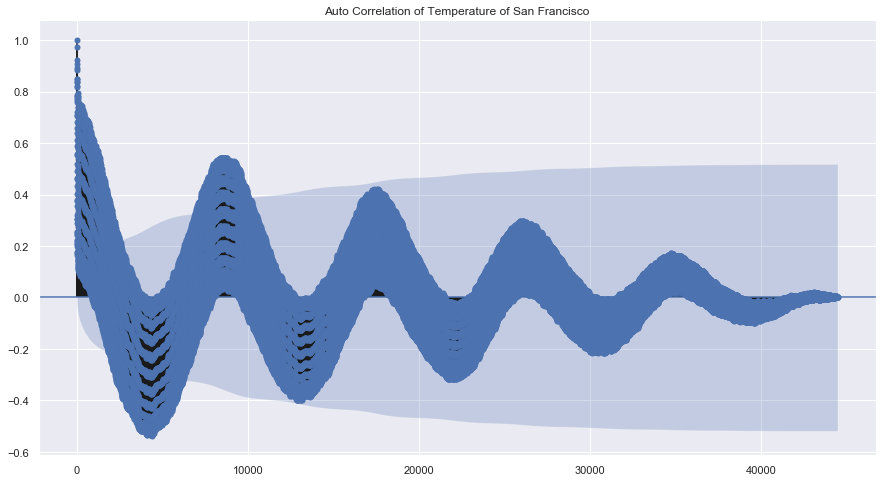

In [40]:
# Autocorrelation of Temperature of San Francisco
plt.rcParams["figure.figsize"] = [15,8]
plot_acf(SF["Temperature"],title="Auto Correlation of Temperature of San Francisco")
plt.show()

###### The above plot shows the lag value along the x-axis and the correlation on the y-axis between -1 and 1. Confidence intervals are drawn as a shaded cone. By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this cone are very likely a correlation and not a statistical fluke. The below plot shows the with a smaller lag value. all the points except are first point are out side the confidence interfval.So they are statistically significant.

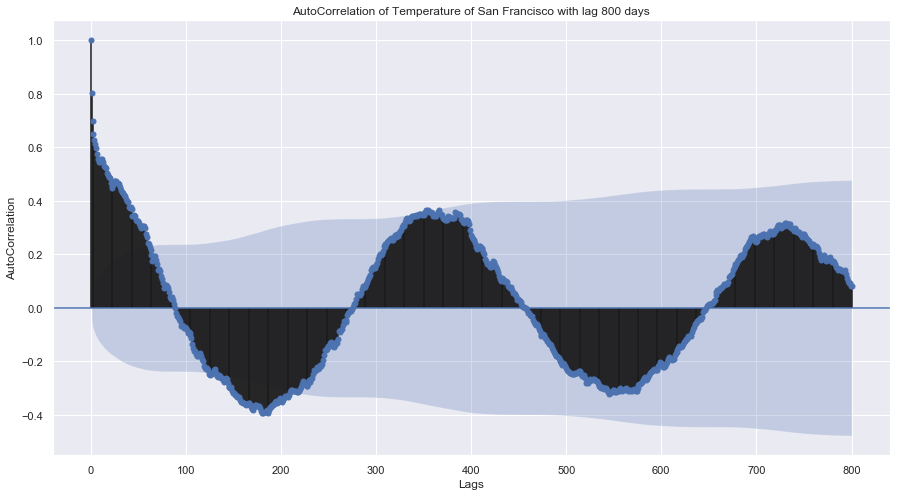

In [41]:
# AutoCorrelation of Temperature of San Francisco 
# Daily frequency and 400 days lag period
lag = 800
f, ax = plt.subplots(1,1)
plot_acf(SF["Temperature"].asfreq('D'), ax = ax, lags = lag, title="AutoCorrelation of Temperature of San Francisco with lag {} days".format(lag))
ax.set_xlabel('Lags')
ax.set_ylabel('AutoCorrelation')
plt.show()

###### The above plot shows the ACF plot for 800 days. Plot shows that the correlation value for days less than ~55 days are outside 95 % confidence interval. These values are coorelated. Also values around a year(~365 days) are outside the 95% confidence interval which shows that those values are also correlated. Values around 120-240 are also outside 95% confidence interval. Theay are also -vely correlated.

### Partial Auto Correlation Factor Plot
##### A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.
##### The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags — Page 81, Section 4.5.6 Partial Autocorrelations, Introductory Time Series with R.
##### In the plot below all the points lie outside the confidence interval. So all the lags are statically significant.

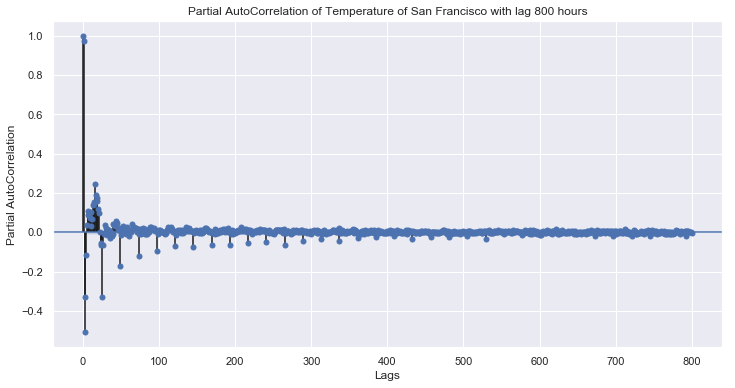

In [42]:
# Partial Autocorrelation of Temperature of San Francisco
plt.rcParams["figure.figsize"] = [12,6]
f, ax = plt.subplots(1,1)
plot_pacf(SF['Temperature'], lags = lag, ax = ax, title="Partial AutoCorrelation of Temperature of San Francisco with lag {} hours".format(lag))
ax.set_xlabel('Lags')
ax.set_ylabel('Partial AutoCorrelation')
plt.show()

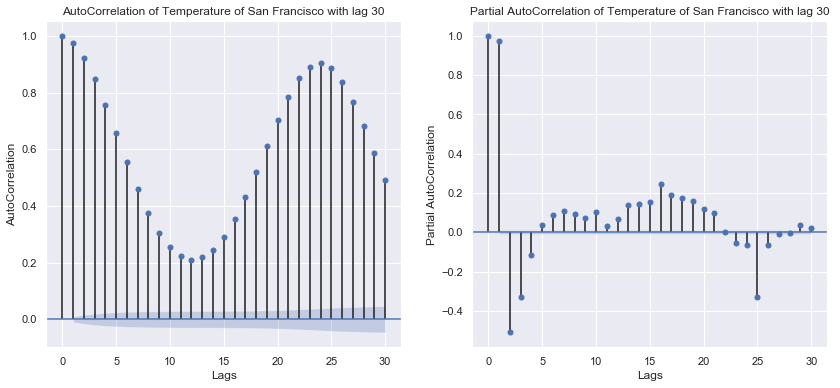

In [43]:
# AutoCorrelation of Temperature of San Francisco
plt.rcParams["figure.figsize"] = [14, 6]
lag = 30
f, (ax0, ax1) = plt.subplots(1, 2, sharex = False, sharey = False)
plot_acf(SF["Temperature"], ax = ax0, lags = lag, title="AutoCorrelation of Temperature of San Francisco with lag {}".format(lag))
ax0.set_xlabel('Lags')
ax0.set_ylabel('AutoCorrelation')

# Partial Autocorrelation of Temperature of San Francisco
plot_pacf(SF['Temperature'], lags = lag, ax = ax1, title="Partial AutoCorrelation of Temperature of San Francisco with lag {}".format(lag))
ax1.set_xlabel('Lags')
ax1.set_ylabel('Partial AutoCorrelation')

plt.show()

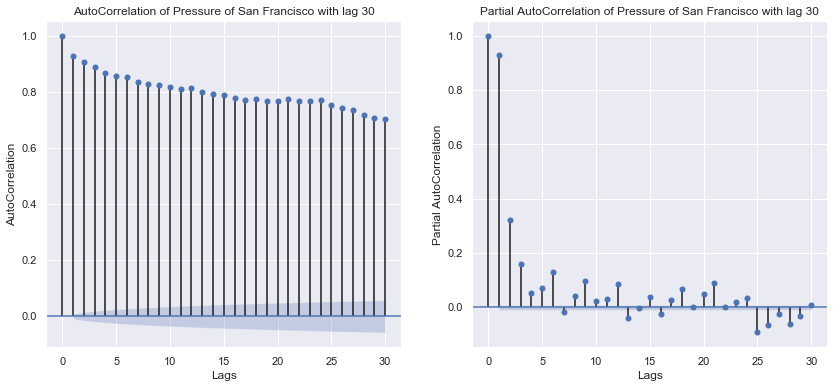

In [44]:
# AutoCorrelation of Pressure of San Francisco
plt.rcParams["figure.figsize"] = [14, 6]
#lag = 25
f, (ax0, ax1) = plt.subplots(1, 2, sharex = False, sharey = False)
plot_acf(SF["Pressure"], ax = ax0, lags = lag, title="AutoCorrelation of Pressure of San Francisco with lag {}".format(lag))
ax0.set_xlabel('Lags')
ax0.set_ylabel('AutoCorrelation')

# Partial Autocorrelation of Pressure of San Francisco
plot_pacf(SF['Pressure'], lags = lag, ax = ax1, title="Partial AutoCorrelation of Pressure of San Francisco with lag {}".format(lag))
ax1.set_xlabel('Lags')
ax1.set_ylabel('Partial AutoCorrelation')

plt.show()

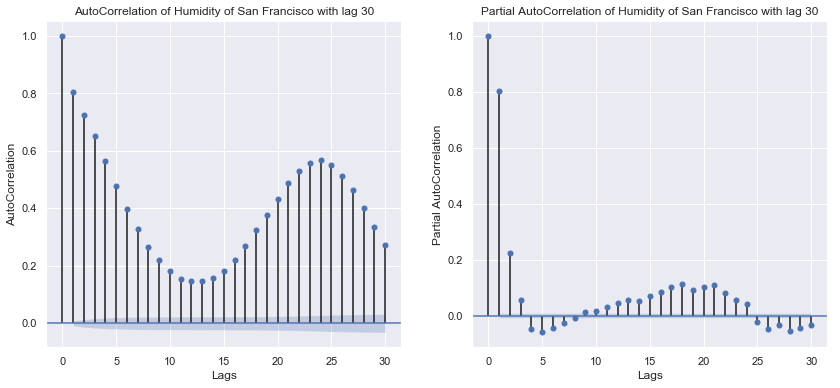

In [45]:
# AutoCorrelation of Humidity of San Francisco
plt.rcParams["figure.figsize"] = [14, 6]
#lag = 25
f, (ax0, ax1) = plt.subplots(1, 2, sharex = False, sharey = False)
plot_acf(SF["Humidity"], ax = ax0, lags = lag, title="AutoCorrelation of Humidity of San Francisco with lag {}".format(lag))
ax0.set_xlabel('Lags')
ax0.set_ylabel('AutoCorrelation')

# Partial Autocorrelation of Pressure of San Francisco
plot_pacf(SF['Humidity'], lags = lag, ax = ax1, title="Partial AutoCorrelation of Humidity of San Francisco with lag {}".format(lag))
ax1.set_xlabel('Lags')
ax1.set_ylabel('Partial AutoCorrelation')

plt.show()

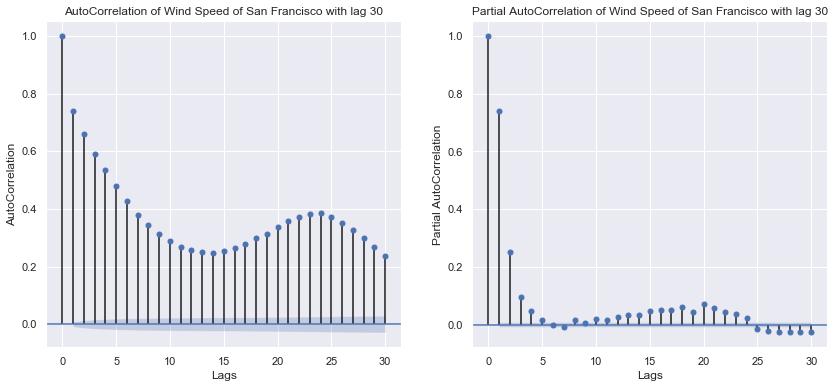

In [46]:
# AutoCorrelation of Wind Speed of San Francisco
plt.rcParams["figure.figsize"] = [14, 6]
#lag = 25
f, (ax0, ax1) = plt.subplots(1, 2, sharex = False, sharey = False)
plot_acf(SF["Wind Speed"], ax = ax0, lags = lag, title="AutoCorrelation of Wind Speed of San Francisco with lag {}".format(lag))
ax0.set_xlabel('Lags')
ax0.set_ylabel('AutoCorrelation')

# Partial Autocorrelation of Pressure of San Francisco
plot_pacf(SF['Wind Speed'], lags = lag, ax = ax1, title="Partial AutoCorrelation of Wind Speed of San Francisco with lag {}".format(lag))
ax1.set_xlabel('Lags')
ax1.set_ylabel('Partial AutoCorrelation')

plt.show()

### Intuition of ACF and PACF 
###### The ACF for the AR(k) time series is strong to a lag of k and the inertia of that relationship carry on to subsequent lag values, trailing off at some point as the effect is weakened. We know that the PACF only describes the direct relationship between an observation and its lag. This would suggest that there is no correlation for lag values beyond k. In the ACF plot above, The first correaltion value is strong and then it slowly becomes week in subsequent lags. In PACF plot, the correlation value become negative after 2nd value. This indicates that AR model will work on this time series with a value p = 2 for ARIMA model.

## MultiVariate Analysis
###### Multivariate time series has more than one time-dependent variable. Each variable depends not only on its past values but also has some dependency on other variables. This dependency is used for forecasting future values.
###### I will use Vector Auto Regression (VAR) algorithm for multivariate weather forecast. In a VAR model, each variable is a linear function of the past values of itself and the past values of all the other variables.

### Johansen Cointegration Test
###### Cointegration is a statistical property of a collection (X1, X2, ..., Xk) of time series variables. First, all of the series must be integrated of order d (see Order of integration). Next, if a linear combination of this collection is integrated of order less than d, then the collection is said to be co-integrated.
###### In the Johansen test, we check whether lambda has a zero eigenvalue. When all the eigenvalues are zero, that would mean that the series are not cointegrated, whereas when some of the eigenvalues contain negative values, it would imply that a linear combination of the time series can be created, which would result in stationarity.
The results below show that 4 vectors of 4 weather attributes are co-integrated.

In [47]:
#checking stationarity
N, l = SF.shape
print(N, l)
jres = coint_johansen(SF,0,1)   # 0 = No trend, Constant term in polynomial, 1 = 1 laggad difference in the model

trstat = jres.lr1                       # trace statistic
tsignf = jres.cvt                       # critical values
#print(trstat)
#print(tsignf)
for i in range(l):
    if trstat[i] > tsignf[i, 1]:     # 0: 90%  1:95% 2: 99%
        r = i + 1
        jres.r = r
        jres.evecr = jres.evec[:, :r]
        print("This is cointegrated ", i)
        
print("There are ", jres.r, "cointegration vectors")
print('Eigen vectors')
print(jres.evecr)
print('Eigen Values')
print(jres.eig)
print('T statistics')
print(jres.lr1)
print('Eigen Statistics')
print(jres.lr2)

44460 5
This is cointegrated  0
This is cointegrated  1
This is cointegrated  2
This is cointegrated  3
This is cointegrated  4
There are  5 cointegration vectors
Eigen vectors
[[ 1.37585402e-02  2.59871981e-02 -2.42835657e-02  1.12230628e-01
  -5.00506671e-03]
 [ 1.13574519e-01  1.54007382e+00 -1.14896534e+00  1.01861626e+00
  -4.70225046e+00]
 [-6.25061052e-03 -1.14881964e-02  5.48796922e-02  3.15767121e-02
  -5.29125753e-03]
 [-1.47250829e+03 -6.69704628e+00  2.70300826e+00  2.14489536e+00
   7.41822709e+00]
 [ 1.47245231e+03  6.89141361e+00 -2.61240144e+00 -2.17748850e+00
  -7.41919479e+00]]
Eigen Values
[0.99041894 0.0801179  0.07686362 0.03286422 0.01905939]
T statistics
[216248.81046622   9609.49957837   5896.82221747   2341.1468724
    855.52149651]
Eigen Statistics
[206639.31088785   3712.6773609    3555.67534507   1485.62537588
    855.52149651]


## Weather Statistics of different cities

##### Hottest and Coldest cities
Plot below show that Phoenix is the hottest city of all the cities in the dataset and Minneapolis is the coldest citiy.

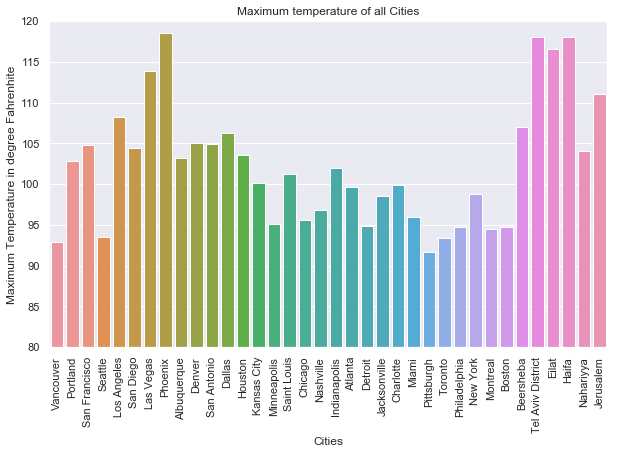

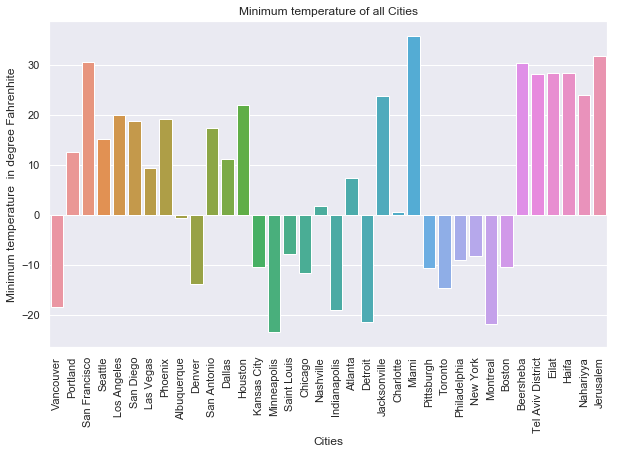

In [48]:
# Plot graphs for minimum and maximum temperature
plt.rcParams["figure.figsize"] = [10, 6]
cols = temperature.shape[1]

#ax1 = plt.subplot(2,1,1)
x = np.linspace(0, cols - 1, cols)
g = sns.barplot(x, temperature.max())

plt.title('Maximum temperature of all Cities')
plt.xlabel('Cities')
plt.ylabel('Maximum Temperature in degree Fahrenhite')
plt.ylim([80, 120])
plt.xticks(x, temperature.columns, rotation='vertical')
plt.show() 

#ax2 = plt.subplot(2,1,2)
g = sns.barplot(x, temperature.min())
plt.title('Minimum temperature of all Cities')
plt.xlabel('Cities')
plt.ylabel('Minimum temperature  in degree Fahrenhite')
#plt.ylim([0.5, 0.65])
plt.xticks(x, temperature.columns, rotation='vertical')

plt.show() 

#### Most Humid and Least Humid City

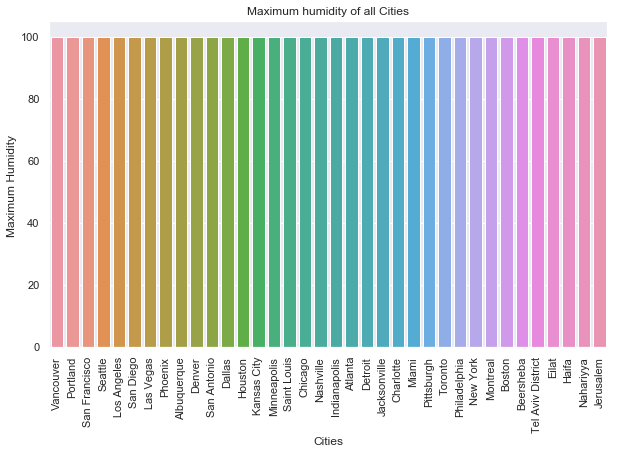

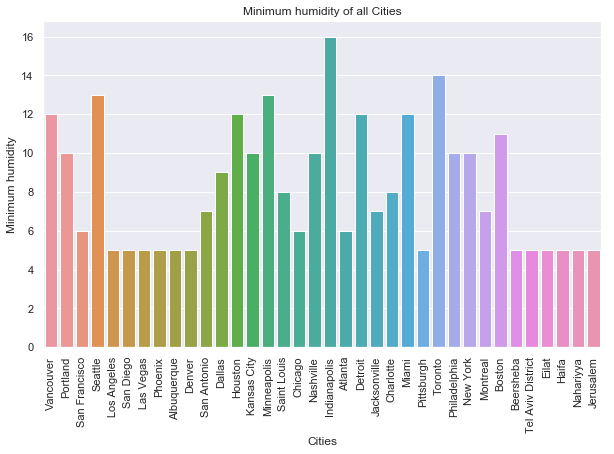

In [49]:
# Plot graphs for Most and Least Humid City
plt.rcParams["figure.figsize"] = [10, 6]
cols = humidity.shape[1]

x = np.linspace(0, cols - 1, cols)
g = sns.barplot(x, humidity.max())

plt.title('Maximum humidity of all Cities')
plt.xlabel('Cities')
plt.ylabel('Maximum Humidity ')
#plt.ylim([80, 120])
plt.xticks(x, humidity.columns, rotation='vertical')
plt.show() 

g = sns.barplot(x, humidity.min())
plt.title('Minimum humidity of all Cities')
plt.xlabel('Cities')
plt.ylabel('Minimum humidity')
#plt.ylim([0.5, 0.65])
plt.xticks(x, humidity.columns, rotation='vertical')

plt.show() 

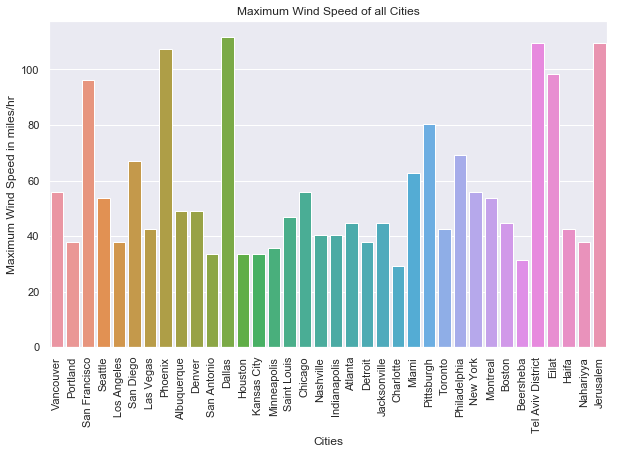

In [50]:
# Plot graphs for Most windy City
plt.rcParams["figure.figsize"] = [10, 6]
cols = humidity.shape[1]

x = np.linspace(0, cols - 1, cols)
g = sns.barplot(x, wind_speed.max())

plt.title('Maximum Wind Speed of all Cities')
plt.xlabel('Cities')
plt.ylabel('Maximum Wind Speed in miles/hr')
#plt.ylim([80, 120])
plt.xticks(x, wind_speed.columns, rotation='vertical')
plt.show() 


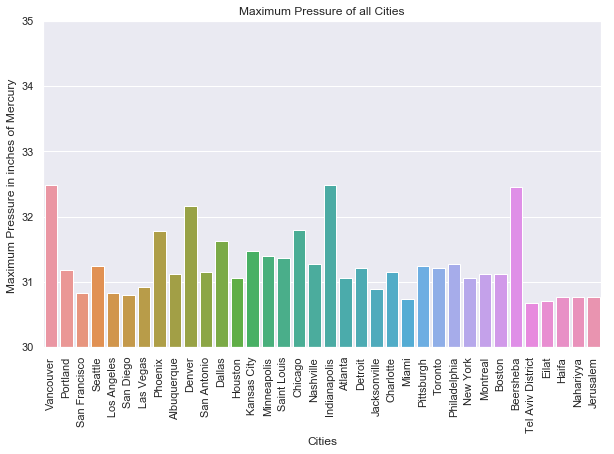

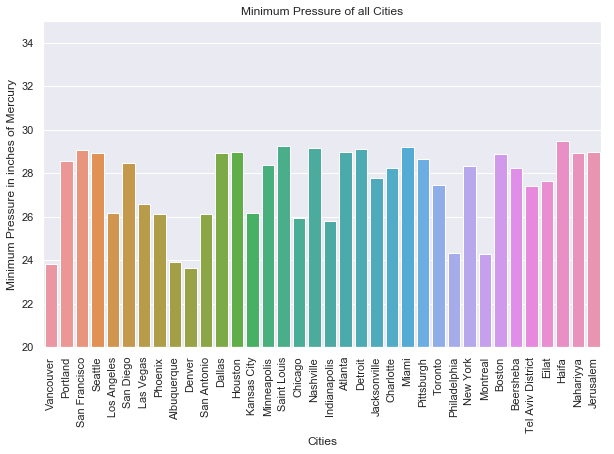

In [51]:
# Plot graphs for Most and Least Pressure City
plt.rcParams["figure.figsize"] = [10, 6]
cols = pressure.shape[1]

x = np.linspace(0, cols - 1, cols)
g = sns.barplot(x, pressure.max())

plt.title('Maximum Pressure of all Cities')
plt.xlabel('Cities')
plt.ylabel('Maximum Pressure in inches of Mercury ')
plt.ylim([30, 35])
plt.xticks(x, pressure.columns, rotation='vertical')
plt.show() 

g = sns.barplot(x, pressure.min())
plt.title('Minimum Pressure of all Cities')
plt.xlabel('Cities')
plt.ylabel('Minimum Pressure in inches of Mercury')
plt.ylim([20, 35])
plt.xticks(x, pressure.columns, rotation='vertical')

plt.show() 